# Playlist Recommendations

<p><img src="https://assets.datacamp.com/production/project_449/img/iphone_music.jpg" alt="Project Image Record" width="600px"></p>

# importing libraries

In [3]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score, KFold
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")

#  Preparing the dataset

In [4]:
import pandas as pd 
tracks=pd.read_csv('fma-rock-vs-hiphop.csv')
echonest_metrics = pd.read_json('echonest-metrics.json',precise_float=True)

# Merge the relevant columns of tracks and echonest_metrics
echo_tracks = echonest_metrics.merge(tracks[['genre_top','track_id']],on='track_id')
echo_tracks

,track_id,acousticness,danceability,energy,instrumentalness,liveness,speechiness,tempo,valence,genre_top
0,2,0.416675,0.675894,0.634476,1.062807e-02,0.177647,0.159310,165.922,0.576661,Hip-Hop
1,3,0.374408,0.528643,0.817461,1.851103e-03,0.105880,0.461818,126.957,0.269240,Hip-Hop
2,5,0.043567,0.745566,0.701470,6.967990e-04,0.373143,0.124595,100.260,0.621661,Hip-Hop
3,134,0.452217,0.513238,0.560410,1.944269e-02,0.096567,0.525519,114.290,0.894072,Hip-Hop
4,153,0.988306,0.255661,0.979774,9.730057e-01,0.121342,0.051740,90.241,0.034018,Rock
...,...,...,...,...,...,...,...,...,...,...
4797,124718,0.412194,0.686825,0.849309,6.000000e-10,0.867543,0.367315,96.104,0.692414,Hip-Hop
4798,124719,0.054973,0.617535,0.728567,7.215700e-06,0.131438,0.243130,96.262,0.399720,Hip-Hop
4799,124720,0.010478,0.652483,0.657498,7.098000e-07,0.701523,0.229174,94.885,0.432240,Hip-Hop
4800,124721,0.067906,0.432421,0.764508,1.625500e-06,0.104412,0.310553,171.329,0.580087,Hip-Hop


# Pairwise relationships between continuous variables

In [5]:
# Create a correlation matrix
corr_metrics = echonest_metrics.corr()
corr_metrics.style.background_gradient()

,track_id,acousticness,danceability,energy,instrumentalness,liveness,speechiness,tempo,valence
track_id,1.000000,-0.279829,0.102056,0.121991,-0.283206,-0.004059,-0.075077,0.004313,0.020201
acousticness,-0.279829,1.000000,-0.189599,-0.477273,0.110033,0.041319,0.038785,-0.110701,-0.085436
danceability,0.102056,-0.189599,1.000000,0.045345,-0.118033,-0.143339,0.171311,-0.094352,0.428515
energy,0.121991,-0.477273,0.045345,1.000000,-0.002412,0.045752,-0.008645,0.227324,0.219384
instrumentalness,-0.283206,0.110033,-0.118033,-0.002412,1.000000,-0.058593,-0.216689,0.023003,-0.145200
liveness,-0.004059,0.041319,-0.143339,0.045752,-0.058593,1.000000,0.073104,-0.007566,-0.017886
speechiness,-0.075077,0.038785,0.171311,-0.008645,-0.216689,0.073104,1.000000,0.032188,0.094794
tempo,0.004313,-0.110701,-0.094352,0.227324,0.023003,-0.007566,0.032188,1.000000,0.129911
valence,0.020201,-0.085436,0.428515,0.219384,-0.145200,-0.017886,0.094794,0.129911,1.000000


# Splitting the data

In [6]:
# Import train_test_split function and Decision tree classifier
from sklearn.model_selection import train_test_split

# Create features
x = echo_tracks.drop(['genre_top','track_id'],axis=1)

# Create labels
y = echo_tracks['genre_top']

# Balance the target column

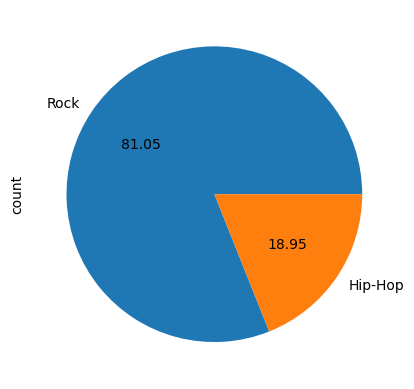

In [7]:
y.value_counts().plot.pie(autopct='%.2f');

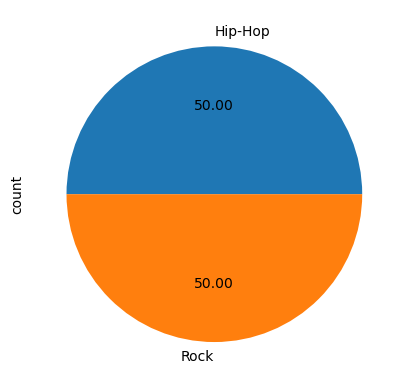

In [8]:
from imblearn.under_sampling import RandomUnderSampler

rus = RandomUnderSampler(sampling_strategy = 1)

x_res ,y_res =rus.fit_resample(x,y)

ax = y_res.value_counts().plot.pie(autopct='%.2f')

In [9]:
x_train, x_test, y_train, y_test = train_test_split(x_res,y_res,random_state=10)

# Feature Scaling

In [10]:
# Import the StandardScaler
from sklearn.preprocessing import StandardScaler

# Scale the features and set the values to a new variable
scaler = StandardScaler()

# Scale train_features and test_features
scaled_train_features= scaler.fit_transform(x_train)
scaled_test_features = scaler.transform(x_test)

# PCA

<p>Now that we have preprocessed our data, we are ready to use PCA to determine by how much we can reduce the dimensionality of our data. We can use <strong>scree-plots</strong> and <strong>cumulative explained ratio plots</strong> to find the number of components to use in further analyses.</p>
<p>Scree-plots display the number of components against the variance explained by each component, sorted in descending order of variance. Scree-plots help us get a better sense of which components explain a sufficient amount of variance in our data. When using scree plots, an 'elbow' (a steep drop from one data point to the next) in the plot is typically used to decide on an appropriate cutoff.</p>

[0.25661373 0.16698452 0.14436456 0.13637408 0.09672052 0.08676694
 0.06687974 0.04529591]
8


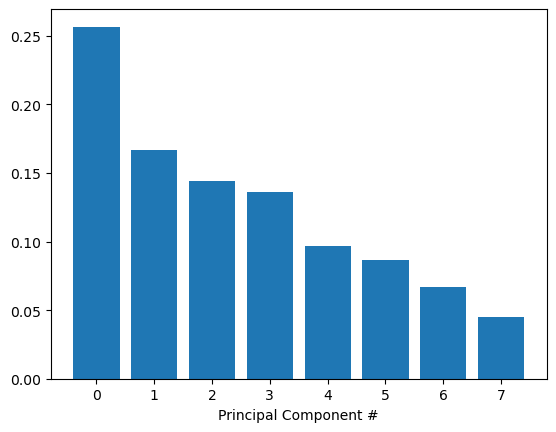

In [11]:
# This is just to make plots appear in the notebook
%matplotlib inline

# Import our plotting module, and PCA class
import matplotlib.pyplot as plt 
from sklearn.decomposition import PCA

# Get our explained variance ratios from PCA using all features
pca = PCA() 
pca.fit(scaled_train_features)
exp_variance = pca.explained_variance_ratio_
print(pca.explained_variance_ratio_)
print(pca.n_components_)

# plot the explained variance using a barplot
fig, ax = plt.subplots()
ax.bar(range(pca.n_components_),exp_variance)
ax.set_xlabel('Principal Component #');


Unfortunately, there does not appear to be a clear elbow in this scree plot, which means it is not straightforward to find the number of intrinsic dimensions using this method.

But all is not lost! Instead, we can also look at the cumulative explained variance plot to determine how many features are required to explain, say, about 85% of the variance (cutoffs are somewhat arbitrary here, and usually decided upon by 'rules of thumb'). Once we determine the appropriate number of components, we can perform PCA with that many components, ideally reducing the dimensionality of our data.

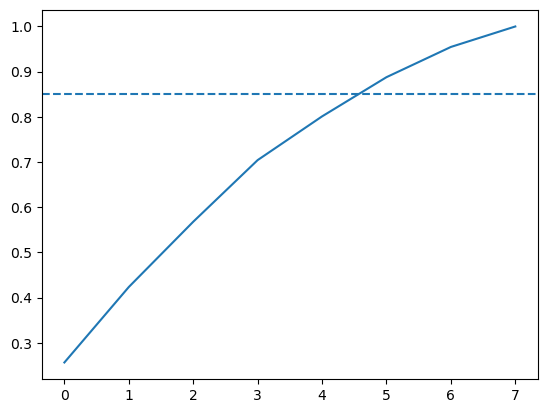

In [12]:
# Import numpy
import numpy as np
# Calculate the cumulative explained variance
cum_exp_variance = np.cumsum(exp_variance)

# Plot the cumulative explained variance and draw a dashed line at 0.85.
fig, ax = plt.subplots()
ax.plot(cum_exp_variance)
ax.axhline(y=0.85, linestyle='--');

# Projecting on our features
<p>We saw from the plot that 6 features (remember indexing starts at 0) can explain 85% of the variance! </p>
<p>Therefore, we can use 6 components to perform PCA and reduce the dimensionality of our train and test features.</p>

In [13]:
# Perform PCA with the chosen number of components and project data onto components
import matplotlib.pyplot as plt 
from sklearn.decomposition import PCA
pca =PCA(n_components=6)

# Fit and transform the scaled training features using pca
train_pca = pca.fit_transform(scaled_train_features)

# Fit and transform the scaled test features using pca
test_pca = pca.transform(scaled_test_features)

# Bulit piplines 

using every possible classifiers i apply piplines for each of them to take a lookand find the best model 


In [10]:
# Define pipelines for different models
tree_pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("pca", PCA(n_components=6)),
    ("tree", DecisionTreeClassifier(random_state=10))
])

logreg_pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("pca", PCA(n_components=6)),
    ("logreg", LogisticRegression(random_state=10))
])

RF_pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("pca", PCA(n_components=6)),
    ("RF", RandomForestClassifier(n_estimators=100, random_state=42))
])
SVC_pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("pca", PCA(n_components=6)),
    ("SVC", SVC(kernel='linear', random_state=42))
])

mlp_pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("pca", PCA(n_components=6)),
    ("MLP", MLPClassifier(hidden_layer_sizes=(100,), max_iter=1000, random_state=42))
])

nb_pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("pca", PCA(n_components=6)),
    ("MLP", GaussianNB())
])

GBC_pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("pca", PCA(n_components=6)),
    ("GBC", GradientBoostingClassifier())
])

knn_pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("pca", PCA(n_components=6)),
    ("KNN", KNeighborsClassifier(n_neighbors=5))
])


# Scoring them to see the heighest accuracy 

In [20]:

# Initialize different models
models = [
    DecisionTreeClassifier(random_state=10),
    LogisticRegression(random_state=10),
    RandomForestClassifier(n_estimators=100, random_state=42),
    SVC(kernel='linear', random_state=42),
    MLPClassifier(hidden_layer_sizes=(100,), max_iter=1000, random_state=42),
    GaussianNB(),
    GradientBoostingClassifier(),
    KNeighborsClassifier(n_neighbors=5)
]

model_names = ['Decision Tree', 'Logistic Regression', 'Random Forest',
               'SVM', 'MLP', 'Naive Bayes', 'Gradient Boosting', 'KNN']

# Train each model and evaluate accuracy
accuracies = {}
for model, name in zip(models, model_names):
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    acc = accuracy_score(y_test, y_pred)
    accuracies[name] = acc
    print(f"{name}:\n", classification_report(y_test, y_pred))


Decision Tree:
               precision    recall  f1-score   support

     Hip-Hop       0.81      0.83      0.82       225
        Rock       0.83      0.81      0.82       230

    accuracy                           0.82       455
   macro avg       0.82      0.82      0.82       455
weighted avg       0.82      0.82      0.82       455

Logistic Regression:
               precision    recall  f1-score   support

     Hip-Hop       0.83      0.85      0.84       225
        Rock       0.85      0.83      0.84       230

    accuracy                           0.84       455
   macro avg       0.84      0.84      0.84       455
weighted avg       0.84      0.84      0.84       455

Random Forest:
               precision    recall  f1-score   support

     Hip-Hop       0.86      0.91      0.89       225
        Rock       0.90      0.86      0.88       230

    accuracy                           0.88       455
   macro avg       0.88      0.88      0.88       455
weighted avg       0

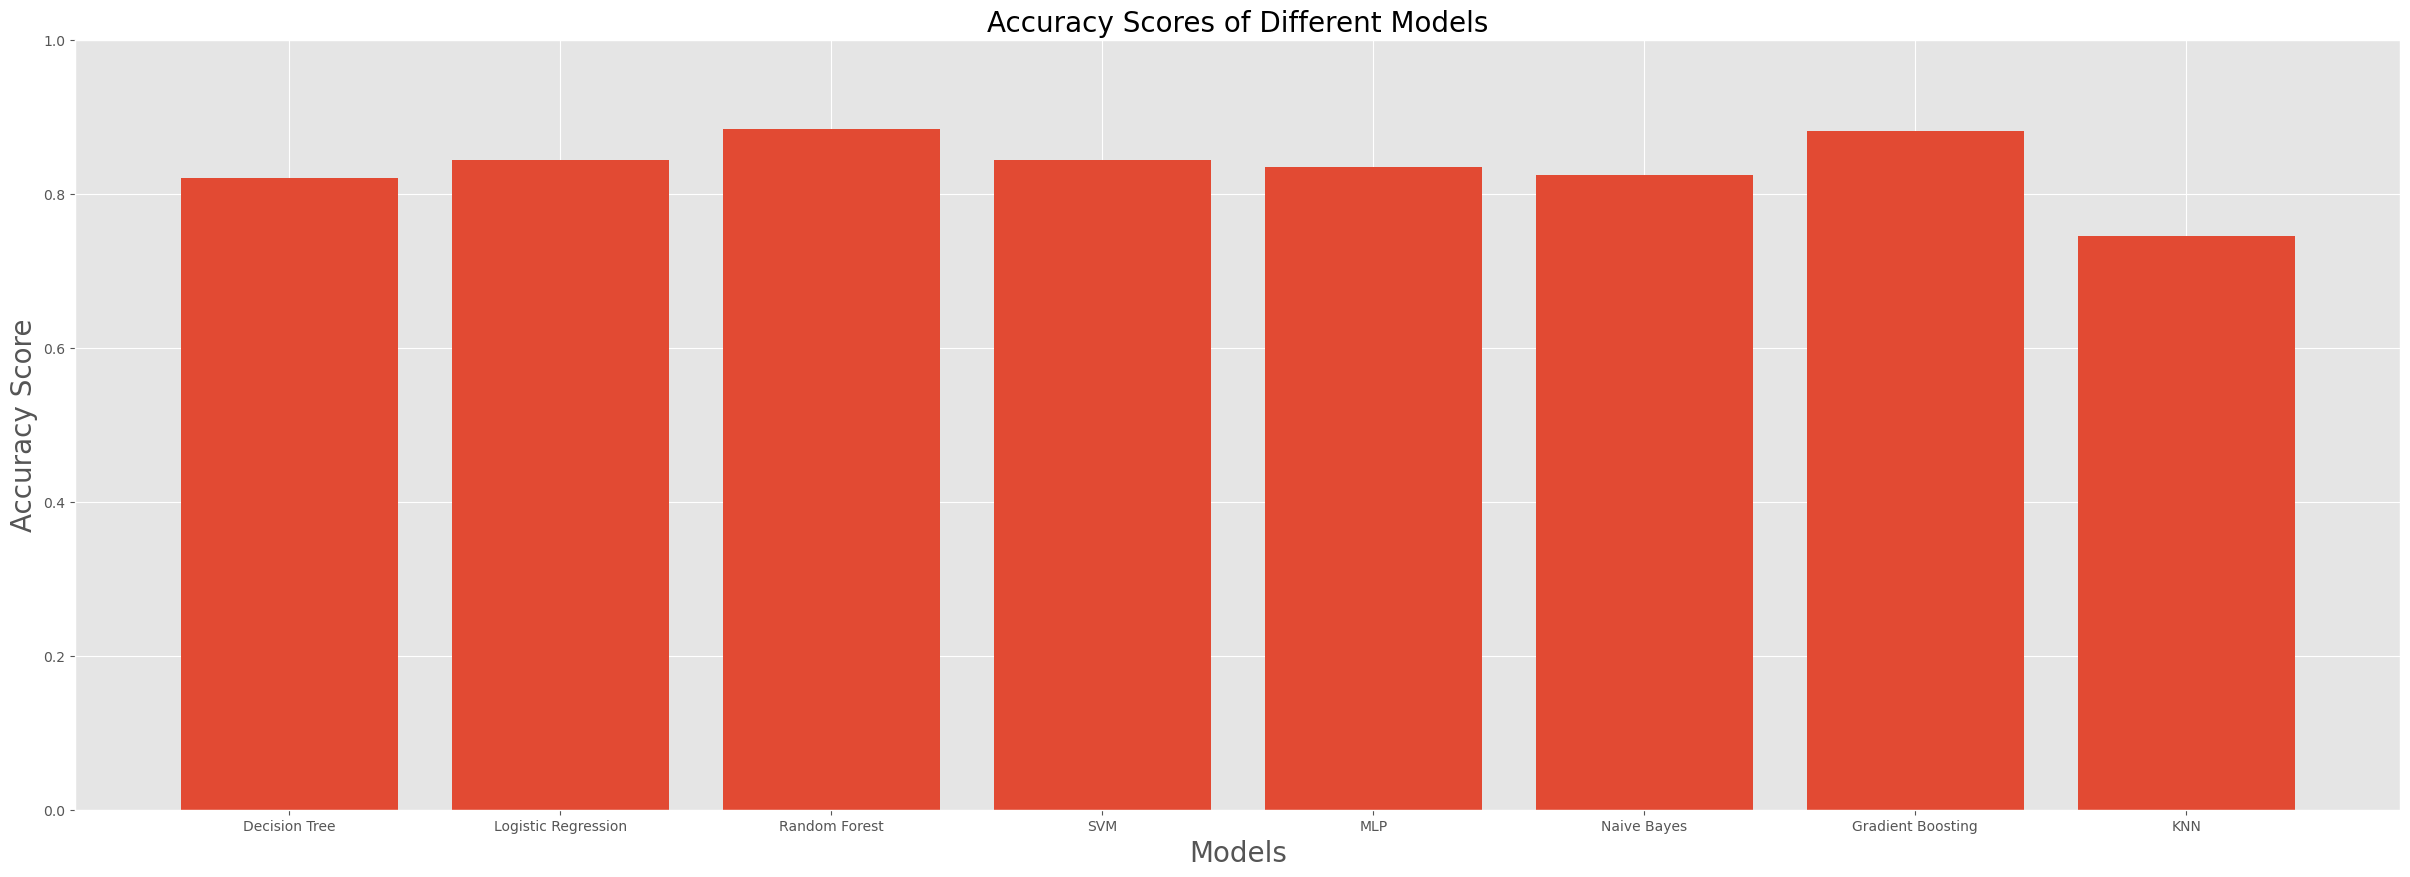

In [31]:
# Plot the bar chart
plt.figure(figsize=(30,10))
plt.bar(accuracies.keys(), accuracies.values())
plt.xlabel('Models', fontsize=20)
plt.ylabel('Accuracy Score', fontsize=20)
plt.title('Accuracy Scores of Different Models',fontsize=20)
plt.ylim([0, 1])
plt.show()